# 03_sec-adp-func

In [1]:
import os
import time
import pickle
import cv2
import numpy.matlib
import tensorflow as tf
import skimage.color as imgco
import skimage.io as imgio
import multiprocessing
import pandas as pd
import traceback

from utilities import *
from lib.crf import crf_inference

from DSRG import DSRG
from SEC import SEC

import argparse
from model import Model

MODEL_WSSS_ROOT = '../database/models_wsss'

In [2]:
method = 'SEC'
dataset = 'ADP-func'
phase = 'predict'
seed_type = 'VGG16'
if dataset in ['ADP-morph', 'ADP-func']:
    setname = 'segtest'
    sess_id = dataset + '_' + setname + '_' + seed_type
else:
    sess_id = dataset + '_' + seed_type
h, w = (321, 321)
seed_size = 41
batch_size = 16
should_saveimg = False
verbose = True

parser = argparse.ArgumentParser()
parser.add_argument('-m', '--method', help='The WSSS method to be used (either SEC or DSRG)', type=str)
parser.add_argument('-d', '--dataset', help='The dataset to run on (either ADP-morph, ADP-func, VOC2012, '
                                            'DeepGlobe_train75, or DeepGlobe_train37.5)', type=str)
parser.add_argument('-n', '--setname', help='The name of the segmentation validation set in the ADP dataset, if '
                                            'applicable (either tuning or segtest)', type=str)
parser.add_argument('-s', '--seed', help='The type of classification network to use for seeding (either VGG16, X1.7 for '
                                         'ADP-morph or ADP-func, or M7 for all other datasets)', type=str)
parser.add_argument('-b', '--batchsize', help='The batch size', default=16, type=int)
parser.add_argument('-i', '--saveimg', help='Toggle whether to save output segmentation as images', action='store_true')
parser.add_argument('-v', '--verbose', help='Toggle verbosity of debug messages', action='store_true')
args = parser.parse_args(['--method', method, '--dataset', dataset, 
                             '--seed', seed_type, '--setname', setname, '-v'])
mdl = Model(args)
mdl.load()

len:{'train': 14134, 'segtest': 50}


## Build model

In [3]:
mdl.sess = tf.Session()
data_x = {}
data_label = {}
id_of_image = {}
iterator = {}
for val_category in mdl.run_categories[1:]:
    data_x[val_category], data_label[val_category], id_of_image[val_category], \
    iterator[val_category] = mdl.next_batch(category=val_category, max_epochs=1)
first_cat = mdl.run_categories[1]
mdl.model.build(net_input=data_x[first_cat], net_label=data_label[first_cat], net_id=id_of_image[first_cat],
                 phase=first_cat)

mdl.sess.run(tf.global_variables_initializer())
mdl.sess.run(tf.local_variables_initializer())
for val_category in mdl.run_categories[1:]:
    mdl.sess.run(iterator[val_category].initializer)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use the `axis` argument instead

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


## Load model from file

In [4]:
# Resume training from latest checkpoint if it exists
saver = tf.train.Saver(max_to_keep=1, var_list=mdl.model.trainable_list)
latest_ckpt = mdl.get_latest_checkpoint()
if latest_ckpt is not None:
    if verbose:
        print('Loading model from previous checkpoint %s' % latest_ckpt)
    mdl.restore_from_model(saver, latest_ckpt)

Loading model from previous checkpoint ../database/models_wsss\SEC\ADP-func_VGG16\final-0
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../database/models_wsss\SEC\ADP-func_VGG16\final-0


## Predict segmentation on a single batch

In [5]:
val_category = mdl.run_categories[1]
layer = mdl.model.net['rescale_output']
input = mdl.model.net['input']
dropout = mdl.model.net['drop_prob']
img,id_,gt_ = mdl.sess.run([data_x[val_category], id_of_image[val_category], data_label[val_category],])
# Generate predicted segmentation in current batch
output_scale = mdl.sess.run(layer,feed_dict={input:img, dropout:0.0})
img_ids = list(id_)
gt_ = gt_[:, :, :, :3]

In [6]:
j = 0

# Read original image
img_curr = cv2.cvtColor(cv2.imread(os.path.join(mdl.dataset_dir, 'JPEGImages',
                        id_[j].decode('utf-8') + '.jpg')), cv2.COLOR_RGB2BGR)
# Read GT segmentation
if dataset == 'VOC2012' or 'DeepGlobe' in dataset:
    gt_curr = cv2.cvtColor(cv2.imread(os.path.join(mdl.dataset_dir, 'SegmentationClassAug',
                                  id_[j].decode('utf-8') + '.png')), cv2.COLOR_RGB2BGR)
elif dataset == 'ADP-morph':
    gt_curr = cv2.cvtColor(cv2.imread(os.path.join(mdl.dataset_dir, 'SegmentationClassAug', 'ADP-morph',
                                      id_[j].decode('utf-8') + '.png')), cv2.COLOR_RGB2BGR)
elif dataset == 'ADP-func':
    gt_curr = cv2.cvtColor(cv2.imread(os.path.join(mdl.dataset_dir, 'SegmentationClassAug', 'ADP-func',
                                      id_[j].decode('utf-8') + '.png')), cv2.COLOR_RGB2BGR)
# Read predicted segmentation
if 'DeepGlobe' not in dataset:
    pred_curr = cv2.resize(output_scale[j], (gt_curr.shape[1], gt_curr.shape[0]))
    img_curr = cv2.resize(img_curr, (gt_curr.shape[1], gt_curr.shape[0]))
    # Apply dCRF
    pred_curr = crf_inference(img_curr, mdl.model.crf_config_test, mdl.num_classes, pred_curr,
                              use_log=True)
else:
    # Apply dCRF
    pred_curr = crf_inference(np.uint8(img[j]), mdl.model.crf_config_test, mdl.num_classes,
                              output_scale[j], use_log=True)
    pred_curr = cv2.resize(pred_curr, (gt_curr.shape[1], gt_curr.shape[0]))
    
# Read original image
img_curr = cv2.cvtColor(cv2.imread(os.path.join(mdl.dataset_dir, 'JPEGImages',
                        id_[j].decode('utf-8') + '.jpg')), cv2.COLOR_RGB2BGR)
# Read GT segmentation
if dataset == 'VOC2012' or 'DeepGlobe' in dataset:
    gt_curr = cv2.cvtColor(cv2.imread(os.path.join(mdl.dataset_dir, 'SegmentationClassAug',
                                  id_[j].decode('utf-8') + '.png')), cv2.COLOR_RGB2BGR)
elif dataset == 'ADP-morph':
    gt_curr = cv2.cvtColor(cv2.imread(os.path.join(mdl.dataset_dir, 'SegmentationClassAug', 'ADP-morph',
                                      id_[j].decode('utf-8') + '.png')), cv2.COLOR_RGB2BGR)
elif dataset == 'ADP-func':
    gt_curr = cv2.cvtColor(cv2.imread(os.path.join(mdl.dataset_dir, 'SegmentationClassAug', 'ADP-func',
                                      id_[j].decode('utf-8') + '.png')), cv2.COLOR_RGB2BGR)
# Read predicted segmentation
if 'DeepGlobe' not in dataset:
    pred_curr = cv2.resize(output_scale[j], (gt_curr.shape[1], gt_curr.shape[0]))
    img_curr = cv2.resize(img_curr, (gt_curr.shape[1], gt_curr.shape[0]))
    # Apply dCRF
    pred_curr = crf_inference(img_curr, mdl.model.crf_config_test, mdl.num_classes, pred_curr,
                              use_log=True)
else:
    # Apply dCRF
    pred_curr = crf_inference(np.uint8(img[j]), mdl.model.crf_config_test, mdl.num_classes,
                              output_scale[j], use_log=True)
    pred_curr = cv2.resize(pred_curr, (gt_curr.shape[1], gt_curr.shape[0]))

Text(0.5, 1.0, 'Functional\n ground truth')

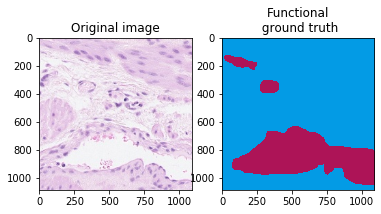

In [7]:
plt.figure
plt.subplot(121)
plt.imshow(img_curr.astype('uint8'))
plt.title('Original image')
plt.subplot(122)
plt.imshow(gt_curr.astype('uint8'))
plt.title('Functional\n ground truth')

In [11]:
Y_raw = np.zeros((gt_curr.shape[0], gt_curr.shape[1], 3))
P_raw = cv2.resize(output_scale[j], (gt_curr.shape[1], gt_curr.shape[0]))
for k, gt_colour in enumerate(mdl.label2rgb_colors):
    pred_mask = np.argmax(P_raw, axis=-1) == k
    Y_raw += np.expand_dims(pred_mask, axis=2) * np.expand_dims(np.expand_dims(gt_colour, axis=0), axis=0)
Y = np.zeros((gt_curr.shape[0], gt_curr.shape[1], 3))
P = cv2.resize(pred_curr, (gt_curr.shape[1], gt_curr.shape[0]))
for k, gt_colour in enumerate(mdl.label2rgb_colors):
    pred_mask = np.argmax(P, axis=-1) == k
    Y += np.expand_dims(pred_mask, axis=2) * np.expand_dims(np.expand_dims(gt_colour, axis=0), axis=0)

Text(0.5, 1.0, 'Post-CRF Prediction')

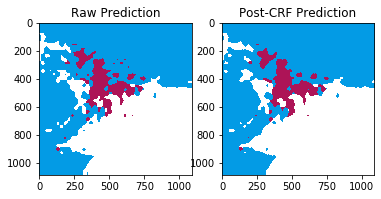

In [12]:
plt.figure
plt.subplot(121)
plt.imshow(Y_raw.astype('uint8'))
plt.title('Raw Prediction')
plt.subplot(122)
plt.imshow(Y.astype('uint8'))
plt.title('Post-CRF Prediction')